# Set Up and libraries

In [15]:
%%capture
# Descargamos el dataframe desde data_download.ipynb con las imagenes asociadas.
!wget https://www.dropbox.com/scl/fi/t2ynnlj5s4q9k59byyw0q/reviews_vermont.csv?rlkey=vcu3b6lqd8ahfg69h1h7iwv0b&st=da5p0jzz&dl=0
!wget https://www.dropbox.com/scl/fi/wcawrg8pjxmm3q7a0t9q2/images.zip?rlkey=g85j5mlagpntf3yhgthz011lg&st=xdsk0g2y&dl=0
!mv images.zip?rlkey=g85j5mlagpntf3yhgthz011lg images.zip
!mv reviews_vermont.csv?rlkey=vcu3b6lqd8ahfg69h1h7iwv0b reviews_vermont.csv
!unzip -qq images.zip

In [22]:
%%capture
# Descargamos el dataset asociado de Vermont (tiene toda la informacion).
!wget https://www.dropbox.com/scl/fi/uznju0fkgnwz1yi4cmgol/review-Vermont.json.gz?rlkey=4l3mithogu5c08x5lxe6pbb6t&st=wcprbsjo&dl=0

!wget https://www.dropbox.com/scl/fi/16vy3q077mz01n4r2nml1/meta-Vermont.json.gz?rlkey=zu5joaocmaqdg0p17oj14z5lz&st=kih98lc6&dl=0

!mv review-Vermont.json.gz?rlkey=4l3mithogu5c08x5lxe6pbb6t review-Vermont.json.gz

!mv meta-Vermont.json.gz?rlkey=zu5joaocmaqdg0p17oj14z5lz meta-Vermont.json.gz

In [18]:
%%capture
!pip install pyreclab
!pip install cornac

In [60]:
import pandas as pd
import numpy as np
import json
import gzip
import pyreclab
import random
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
import os
# images
from keras.applications import vgg16, vgg19, ResNet50
from tensorflow.keras.utils import load_img,img_to_array
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
# text
import requests
import heapq
import math
from sklearn.metrics import pairwise_distances
from sklearn.decomposition import PCA
from io import BytesIO
import pickle
import time
# cornac
import cornac
from cornac.data import Reader, Dataset
import cornac.datasets
from cornac.eval_methods import RatioSplit
from cornac.data import TextModality, ImageModality
from cornac.data.text import BaseTokenizer
from cornac.models import PMF, SoRec, WMF, CTR, BPR, VBPR
import torch



In [108]:
def parse(path):
  g = gzip.open(path, 'r')
  for l in g:
    yield json.loads(l)

# Data Preprocessing

In [109]:
metadata = list(parse("meta-Vermont.json.gz"))
reviews = list(parse("review-Vermont.json.gz"))

In [2]:
def image_exists(img_url):
    return img_url in image_files
df = pd.read_csv('reviews_vermont.csv')
print(df.shape) # [TODO: revisar download_data.ipynb]
image_files = os.listdir('images')
df = df[df['img_url'].apply(image_exists)]
print(df.shape)

(15417, 5)
(10514, 5)


In [31]:
df.head()

,user_id,gmap_id,rating,text,img_url
0,108979378435066002945,0x4cb549e8877cf0d7:0xe8f003e6d73392ae,5,Quintessential Vermont experience (even for Ve...,0x4cb549e8877cf0d7:0xe8f003e6d73392ae.png
1,101856865551768948430,0x89e024446398691f:0x4011d3a0f8636036,1,I had them replace two broken studs on my righ...,0x89e024446398691f:0x4011d3a0f8636036.png
2,107787438275893909028,0x4cb446270577ed85:0x8b3dfc93cc4846a8,5,Kingdom Recovery Center is a place for people ...,0x4cb446270577ed85:0x8b3dfc93cc4846a8.png
3,117544587328467760561,0x4cb4462e2f53cf2f:0xfbe0971a8791662,5,"The river is cool, no, the river is cold. It i...",0x4cb4462e2f53cf2f:0xfbe0971a8791662.png
4,105058591299841405589,0x4cb42a9f5df6385b:0x534ca42c250f0a05,5,Took the Mad Brook trail. Definitely not the e...,0x4cb42a9f5df6385b:0x534ca42c250f0a05.png


In [44]:
df_uir = df[['user_id', 'gmap_id', 'rating']]

In [45]:
SIZE = 0.7
n_rows = int(df_uir.shape[0] * SIZE)

In [46]:
X_train, X_test = train_test_split(df_uir, test_size=0.2, random_state=42)

In [47]:
print(X_test.shape[0] + X_train.shape[0], df_uir.shape[0])

10514 10514


In [48]:
X_test.shape, X_train.shape

((2103, 3), (8411, 3))

In [49]:
X_train.to_csv('reviews_train.csv', index=False)
X_test.to_csv('reviews_test.csv', index=False)

# Models

## Most popular

In [50]:
model_mp = pyreclab.MostPopular(
    dataset= 'reviews_train.csv',
    header = True,
    usercol = 0,
    itemcol = 1,
    ratingcol = 2
)

In [51]:
model_mp.train(progress=True)

In [52]:
reclist, map, ndcg = model_mp.testrec(
    input_file = 'reviews_test.csv',
    header = True,
    usercol = 0,
    itemcol = 1,
    ratingcol = 2,
    topn = 10,
    output_file = 'results.csv',
    relevance_threshold = 3.5,
    includeRated = False
)

In [53]:
def find_user(user_id):
    for review in reviews:
        review_uid = review['user_id']
        if review_uid != user_id: continue
        user_name = review['name']
        return user_name


In [54]:
users = list(reclist.keys())
user_1 = random.choice(users)
user_name = find_user(user_1)
user_reclist = reclist[user_1]
print(user_name)

Greg Boyd


### Ejemplo

In [95]:
def show_recommendations(user, reclist):
    rec_business_cols = {
        'name' : [],
        'description' : [],
        'url' : [],
        'categories': []

    }
    for d in metadata:
        if d['gmap_id'] not in reclist: continue
        categories = ", ".join(d['category'])

        rec_business_cols['name'].append(d['name'])
        rec_business_cols['description'].append(d['description'])
        rec_business_cols['url'].append(d['url'])

        rec_business_cols['categories'].append(categories)

    reclist_df = pd.DataFrame(rec_business_cols)
    return reclist_df

In [56]:
show_recommendations(user_1, user_reclist)

,name,description,url,categories
0,Vermont Teddy Bear,None,https://www.google.com/maps/place//data=!4m2!3...,"Gift shop, Group accommodation, Store, Tourist..."
1,Jay Peak Resort,"Ideal for skiing, this mountainside resort als...",https://www.google.com/maps/place//data=!4m2!3...,"Ski resort, Golf course, Ice skating rink, Res..."
2,Bennington Battle Monument,This 306-ft. stone obelisk offers an elevator ...,https://www.google.com/maps/place//data=!4m2!3...,"Monument, Historical place, Tourist attraction"
3,Stowe Mountain Resort,Ski resort with 2 mountains & more than 100 tr...,https://www.google.com/maps/place//data=!4m2!3...,"Ski resort, Day care center, Outdoor clothing ..."
4,The Lodge at Spruce Peak,"High-end, Alpine-style resort with refined lod...",https://www.google.com/maps/place//data=!4m2!3...,"Resort hotel, Event venue, Hotel, Massage spa,..."
5,The Alchemist Stowe,None,https://www.google.com/maps/place//data=!4m2!3...,Brewery
6,Simon Pearce,Restaurant serving refined American meals in a...,https://www.google.com/maps/place//data=!4m2!3...,"American restaurant, Bar, Glass, Glass & mirro..."
7,Sugarbush Farm,Rural farm producing cheese varieties & maple ...,https://www.google.com/maps/place//data=!4m2!3...,"Tourist attraction, Cheese shop, Farm"
8,Cold Hollow Cider Mill,Charming spot with a bakery known for cider do...,https://www.google.com/maps/place//data=!4m2!3...,"Cider mill, Bakery, Cafe, Deli, Donut shop, Fo..."
9,Idletyme Brewing Company,Beer-centric bistro serving American classics ...,https://www.google.com/maps/place//data=!4m2!3...,"Brewery, American restaurant, Bar, Brewpub"


### Metricas

In [57]:
def metrics(user_id, reclist):
    parameters = (user_id, reclist, 10, 3.5, False)
    auc = round(model_mp.AUC(*parameters), 6)
    ndcg = model_mp.nDCG(*parameters)
    print(f'MAP@10: {map}')
    print(f'DCG@10: {ndcg}')


In [58]:
metrics(user_1, user_reclist)

MAP@10: 0.01974601430439316
DCG@10: 0.0


## Random

In [59]:
def precision_at_k(r, k):
    assert 1 <= k <= r.size
    return (np.asarray(r)[:k] != 0).mean()

def average_precision_at_k(r, k):
    r = np.asarray(r)
    score = 0.
    for i in range(min(k, r.size)):
        score += precision_at_k(r, i + 1)
    return score / k

def dcg_at_k(r, k):
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(np.subtract(np.power(2, r), 1) / np.log2(np.arange(2, r.size + 2)))
    return 0.

def idcg_at_k(k):
    return dcg_at_k(np.ones(k), k)

def ndcg_at_k(r, k, max_relevant):
    idcg = idcg_at_k(min(k, max_relevant))
    if not idcg:
        return 0.
    return dcg_at_k(r, k) / idcg

def evaluate_model(random_reclist, n):
    mean_ap = 0.
    mean_ndcg = 0.
    for u in user_items_test.keys():
        reclist = random_reclist[u]
        rel_vector = [np.isin(user_items_test[u], reclist, assume_unique=True).astype(int)]
        mean_ap += average_precision_at_k(rel_vector, n)
        mean_ndcg += ndcg_at_k(rel_vector, n, len(user_items_test[u]))

    mean_ap /= len(user_items_test)
    mean_ndcg /= len(user_items_test)

    return mean_ap, mean_ndcg


In [60]:
user_items_train = {}
itemset = set()

for row in X_train.itertuples():
    if row[1] not in user_items_train:
        user_items_train[row[1]] = []

    user_items_train[row[1]].append(row[2])
    itemset.add(row[2])

itemset = np.sort(list(itemset))


user_items_test = {}

for row in X_test.itertuples():
    if row[1] not in user_items_test:
        user_items_test[row[1]] = []

    user_items_test[row[1]].append(row[2])

In [61]:
random_recommendations = {}

for user_id in X_test['user_id'].to_list():
    reclist = set(random.sample(X_train['gmap_id'].to_list(), k=10))
    random_recommendations[user_id] = reclist

### Ejemplo

In [62]:
user_2 = random.choice(list(user_items_test.keys()))

In [63]:
show_recommendations(user_2, random_recommendations[user_2])

,name,description,url,categories
0,ALS Towing and Repair,None,https://www.google.com/maps/place//data=!4m2!3...,Towing service
1,Purple Sage,None,https://www.google.com/maps/place//data=!4m2!3...,"Hair salon, Boutique, Spa"
2,Faith's Toyota Ford,None,https://www.google.com/maps/place//data=!4m2!3...,"Toyota dealer, Car dealer, Car finance and loa..."
3,Pastime Pinball,None,https://www.google.com/maps/place//data=!4m2!3...,"Video arcade, Museum"
4,Philo Ridge Farm,None,https://www.google.com/maps/place//data=!4m2!3...,"Farm, Market"
5,Old Soul Barbershop,None,https://www.google.com/maps/place//data=!4m2!3...,Barber shop
6,Happy Hour Restaurant,None,https://www.google.com/maps/place//data=!4m2!3...,American restaurant
7,Quechee Gorge Village,None,https://www.google.com/maps/place//data=!4m2!3...,Shopping mall
8,Toll Road Inn,Simple hotel with mountain views & free contin...,https://www.google.com/maps/place//data=!4m2!3...,"Hotel, Lodging"
9,Waitsfield Covered Bridge,None,https://www.google.com/maps/place//data=!4m2!3...,Bridge


### Metricas

In [64]:
mean_ap, mean_ndcg = evaluate_model(random_recommendations, n=10)
print("nDCG@10", mean_ndcg)
print("MAP@10", mean_ap)


nDCG@10 0.0
MAP@10 0.0


## Multimodal Recsys (v.1.0)

In [8]:
# * Codigo obtenido del practico 4 *

modelo_escogido = 'vgg16' #@param["vgg16", "vgg19"]

if modelo_escogido == 'vgg16':
  # cargar modelo
  vgg_model = vgg16.VGG16(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()

elif modelo_escogido == 'vgg19':
  # cargar modelo
  vgg19_model = vgg19.VGG19(weights='imagenet')
  # quitar la capa de clasificacion
  feat_extractor = Model(inputs=vgg19_model.input, outputs=vgg19_model.get_layer("fc2").output)
  # vemos resumen de la arquitectura del modelo
  feat_extractor.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
imgs_model_width, imgs_model_height = 224, 224

In [4]:
# obtenemos un sampleo de muestras, ya que son muchas imagenes
# -> consume toda la RAM
df_sample = df.sample(frac=0.2)

In [5]:
print(df_sample.value_counts('rating'))
print(df_sample.shape)

rating
5    1611
4     311
3      78
1      67
2      36
Name: count, dtype: int64
(2103, 5)


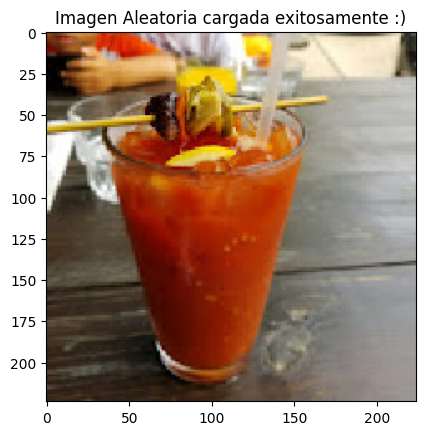

In [6]:
FOLDER = 'images'
files = df_sample['img_url'].tolist()
idx =  random.randint(0, len(files))
original = load_img(f'{FOLDER}/{files[idx]}', target_size=(imgs_model_width, imgs_model_height))
plt.title("Imagen Aleatoria cargada exitosamente :)")
plt.imshow(original)
plt.show()


In [9]:
# En una lista iremos guardando cada imagen preprocesada
all_images = []
for f in files:
    prefix = 'images'
    filename = f'{prefix}/{f}'
    original = load_img(filename, target_size=(imgs_model_width, imgs_model_height))
    numpy_image = img_to_array(original)
    image_batch = np.expand_dims(numpy_image, axis=0)

    all_images.append(image_batch)

images = np.vstack(all_images)

processed_imgs = preprocess_input(images.copy()) # preprocesamos todas las imagenes
imgs_features = feat_extractor.predict(processed_imgs)
print("features extraidos exitosamente! :)")
print(imgs_features.shape)


66/66 ━━━━━━━━━━━━━━━━━━━━ 1422s 22s/step
features extraidos exitosamente! :)
(2103, 4096)


In [11]:
with open('imgs_features.npy', 'wb') as file: # guardamos los embeddings
    np.save(file, imgs_features)

In [75]:
userset = set(df_sample['user_id'].tolist())
itemset = set(df_sample['gmap_id'].tolist())
user_to_idx = {user: idx for idx, user in enumerate(userset)}
item_to_idx = {item: idx for idx, item in enumerate(itemset)}

idx_to_user = {idx: user for user, idx in user_to_idx.items()}
idx_to_item = {idx: item for item, idx in item_to_idx.items()}


In [53]:
VOCAB_SIZE = 5000
item_text_modality = TextModality(
    corpus=df_sample['text'].tolist(),
    id_map=item_to_idx,
    max_vocab=VOCAB_SIZE,
    #tokenizer=BaseTokenizer()
)

In [54]:
item_image_modality = ImageModality(
    features=imgs_features,
    ids=item_to_idx
    )

In [55]:
uir_list = df_sample[['user_id', 'gmap_id', 'rating']].values.tolist()

In [62]:
SEED = 42
VERBOSE = True
USE_GPU = torch.cuda.is_available()


In [59]:
ratio_split = RatioSplit(
    data=uir_list,
    test_size=0.2,
    rating_threshold=3.5,
    item_text=item_text_modality, # agregamos la modalidad de texto
    item_image=item_image_modality, # agregamos la modalidad de imagen
    exclude_unknowns=True,
    seed=SEED,
    verbose=VERBOSE,
)


rating_threshold = 3.5
exclude_unknowns = True
---
Training data:
Number of users = 1469
Number of items = 1111
Number of ratings = 1679
Max rating = 5.0
Min rating = 1.0
Global mean = 4.6
---
Test data:
Number of users = 1469
Number of items = 1111
Number of ratings = 39
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 1469
Total items = 1111


In [117]:
# baseline MostPopular
most_pop = cornac.models.MostPop()

# modelo CDL (Collaborative Deep Learning)
cdl = cornac.models.CDL(
    k=50, # dimension factor latente
    autoencoder_structure=[200],  # N° de neuronas de la capa code/decoder para SDAE
    vocab_size=VOCAB_SIZE, # cantidad maxima de vocabulario
    act_fn='tanh',
    max_iter=50,
    seed=SEED,
    verbose=VERBOSE
)
# modelo VBPR (Visual Bayesian Personalized Ranking)
vbpr = cornac.models.VBPR(
    k=10, # dimension de gamma en el espacio latente
    k2=40,  # dimension de theta en el espacio latente
    n_epochs=50,
    use_gpu=USE_GPU,
    seed=SEED,
    verbose=VERBOSE
)

## Metricas

In [118]:
def get_metrics(n):
    # numero de n elementos en la lista de recomendacion
    RMSE_n = cornac.metrics.RMSE()
    AUC_n = cornac.metrics.AUC()
    MAP_n = cornac.metrics.MAP()
    MRR_n = cornac.metrics.MRR()

    Recall_n = cornac.metrics.Recall(k=n)
    Precision_n = cornac.metrics.Precision(k=n)
    F1_n = cornac.metrics.FMeasure(k=n)
    nDCG_n = cornac.metrics.NDCG(k=n)
    return [RMSE_n, AUC_n, MAP_n, Recall_n, Precision_n, F1_n, nDCG_n, MRR_n]


In [119]:
text_exp = cornac.Experiment(eval_method=ratio_split,
                             models=[most_pop, cdl, vbpr],
                             metrics=get_metrics(n=10))
text_exp.run()


[MostPop] Training started!

[MostPop] Evaluation started!


Rating:   0%|          | 0/39 [00:00<?, ?it/s]

Ranking:   0%|          | 0/37 [00:00<?, ?it/s]


[CDL] Training started!


  0%|          | 0/50 [00:00<?, ?it/s]

Learning completed!

[CDL] Evaluation started!


Rating:   0%|          | 0/39 [00:00<?, ?it/s]

Ranking:   0%|          | 0/37 [00:00<?, ?it/s]


[VBPR] Training started!


Epoch 1/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/17 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/17 [00:00<?, ?it/s]

Optimization finished!

[VBPR] Evaluation started!


Rating:   0%|          | 0/39 [00:00<?, ?it/s]

Ranking:   0%|          | 0/37 [00:00<?, ?it/s]


TEST:
...
        |   RMSE |    AUC |  F1@10 |    MAP |    MRR | NDCG@10 | Precision@10 | Recall@10 | Train (s) | Test (s)
------- + ------ + ------ + ------ + ------ + ------ + ------- + ------------ + --------- + --------- + --------
MostPop | 2.7689 | 0.4360 | 0.0055 | 0.0191 | 0.0217 |  0.0191 |       0.0030 |    0.0303 |    0.0006 |   0.1400
CDL     | 3.6078 | 0.4562 | 0.0110 | 0.0493 | 0.0499 |  0.0494 |       0.0061 |    0.0606 |   44.1013 |   0.1689
VBPR    | 2.3975 | 0.5029 | 0.0055 | 0.0358 | 0.0357 |  0.0303 |       0.0030 |    0.0303 |   19.7262 |   0.2629



# Fuentes:
> [1] Wang, H., Wang, N., & Yeung, D. Y. (2015, August). Collaborative deep learning for recommender systems. In Proceedings of the 21th ACM SIGKDD international conference on knowledge discovery and data mining (pp. 1235-1244).

> [2] He, R., & McAuley, J. (2016, February). VBPR: visual bayesian personalized ranking from implicit feedback. In Thirtieth AAAI Conference on Artificial Intelligence.

Links:

> (1) https://github.com/PreferredAI/tutorials/blob/master/multimodal-recsys/02_multimodality.ipynb

> (2) https://github.com/PreferredAI/tutorials/tree/master

In [120]:
def get_reclist(id_user, model, n):
    """ funcion que retorna la lista de recomendaciones para un usuario.
    Valido solo para modelos de cornac. """
    scores_for_user = model.score(id_user)
    scores_for_user = [
        (idx_to_item[idx], score) for idx, score in enumerate(scores_for_user)
    ]
    scores_for_user.sort(key=lambda x: x[1], reverse=True)
    return [i[0] for i in scores_for_user[:n]]

In [121]:
user_3 = random.choice(list(idx_to_user.keys()))
print("ID Usuario: ", idx_to_user[user_3])

ID Usuario:  104166140726791601540


In [122]:
user3_reclist = get_reclist(user_3, vbpr, 10)
show_recommendations(idx_to_user[user_3], user3_reclist)

,name,description,url,categories
0,River Road Veterinary Clinic,None,https://www.google.com/maps/place//data=!4m2!3...,Veterinarian
1,Sunset Rock RV Park,None,https://www.google.com/maps/place//data=!4m2!3...,"Campground, RV park"
2,Audubon Vermont: Green Mountain Audubon Center,None,https://www.google.com/maps/place//data=!4m2!3...,"Recreation center, Non-profit organization, To..."
3,Pica-Pica Filipino Cuisine,None,https://www.google.com/maps/place//data=!4m2!3...,"Filipino restaurant, Asian restaurant"
4,Pizzeria La Toscanella,"Wood-fired pizzas with a variety of toppings, ...",https://www.google.com/maps/place//data=!4m2!3...,"Pizza restaurant, Restaurant"
5,Henry Covered Bridge,None,https://www.google.com/maps/place//data=!4m2!3...,"Bridge, Tourist attraction"
6,Everybuddy's Casual Dining,None,https://www.google.com/maps/place//data=!4m2!3...,"Family restaurant, Restaurant"
7,Blue Paddle Bistro,"Unpretentious restaurant plating inventive, gl...",https://www.google.com/maps/place//data=!4m2!3...,New American restaurant
8,Taylor Farm,None,https://www.google.com/maps/place//data=!4m2!3...,Farm
9,Townshend Dam Diner,None,https://www.google.com/maps/place//data=!4m2!3...,Restaurant


In [123]:
user3_reclist = get_reclist(user_3, most_pop, 10)
show_recommendations(idx_to_user[user_3], user3_reclist)

,name,description,url,categories
0,Merchants Hall,None,https://www.google.com/maps/place//data=!4m2!3...,"Event venue, Concert hall, Performing arts the..."
1,Bear Pond Books,None,https://www.google.com/maps/place//data=!4m2!3...,Book store
2,Lye Brook Falls,None,https://www.google.com/maps/place//data=!4m2!3...,Tourist attraction
3,Molly Stark State Park,Recreational area along scenic Route 9 with hi...,https://www.google.com/maps/place//data=!4m2!3...,"State park, Campground"
4,Oakledge Park Treehouse,None,https://www.google.com/maps/place//data=!4m2!3...,Tourist attraction
5,Mountain Park Cinema,None,https://www.google.com/maps/place//data=!4m2!3...,Movie theater
6,Vermont Teddy Bear Factory,None,https://www.google.com/maps/place//data=!4m2!3...,"Tourist attraction, Corporate office"
7,Dairy Creme,"Old-fashioned, seasonal ice cream stand sellin...",https://www.google.com/maps/place//data=!4m2!3...,Ice cream shop
8,Smugglers' Notch Base Lodge,"Unassuming, mountainside spot offering a dayti...",https://www.google.com/maps/place//data=!4m2!3...,"American restaurant, Cafeteria, Lounge"
9,Emerald Lake State Park,"Wooded land surrounding a lake with campsites,...",https://www.google.com/maps/place//data=!4m2!3...,"State park, Tourist attraction"


In [124]:
user3_reclist = get_reclist(user_3, cdl, 10)
show_recommendations(idx_to_user[user_3], user3_reclist)

,name,description,url,categories
0,Mountain Man Pizza,None,https://www.google.com/maps/place//data=!4m2!3...,"Pizza Takeout, Pizza restaurant"
1,Ricker Pond State Park,"Campground with tents & cabins, multi-use trai...",https://www.google.com/maps/place//data=!4m2!3...,Campground
2,Heritage Deli & Bakery,None,https://www.google.com/maps/place//data=!4m2!3...,"Sandwich shop, Bakery, Breakfast restaurant, C..."
3,Cedar Circle Farm & Education Center,None,https://www.google.com/maps/place//data=!4m2!3...,"Non-profit organization, Farm, Florist, Fruit ..."
4,Henry Covered Bridge,None,https://www.google.com/maps/place//data=!4m2!3...,"Bridge, Tourist attraction"
5,The Swimming Hole,None,https://www.google.com/maps/place//data=!4m2!3...,"Fitness center, Public swimming pool, Sports club"
6,Oakledge Park,"Located on Lake Champlain, this park has a roc...",https://www.google.com/maps/place//data=!4m2!3...,"Park, Tourist attraction"
7,Tim's Place,None,https://www.google.com/maps/place//data=!4m2!3...,"American restaurant, Breakfast restaurant, Din..."
8,Emerald Lake State Park,"Wooded land surrounding a lake with campsites,...",https://www.google.com/maps/place//data=!4m2!3...,"State park, Tourist attraction"
9,McDonald's,"Classic, long-running fast-food chain known fo...",https://www.google.com/maps/place//data=!4m2!3...,"Fast food restaurant, Breakfast restaurant, Co..."
